## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [5]:
user_grouped_df = df.groupby("user_id")["converted"].sum()
user_grouped_df.head()

user_id
630000    0
630001    1
630002    0
630003    0
630004    0
Name: converted, dtype: int64

In [6]:
total_users = user_grouped_df.shape[0]
user_grouped_df.sum() / total_users

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
def treatment_group_match(row):
    only_treatment = row["group"] == "treatment" and row["landing_page"] != "new_page"
    only_new_page = row["group"] != "treatment" and row["landing_page"] == "new_page"
    return only_treatment or only_new_page
np.sum(df.apply(treatment_group_match, axis=1))

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
rows_to_drop = df.apply(treatment_group_match, axis=1)
drop_indices = rows_to_drop[rows_to_drop == True].index
df2 = df.drop(drop_indices)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2["user_id"].value_counts().head(3)

773192    2
630732    1
811737    1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2.query("user_id=='773192'")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(1899, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.sum() / df2.converted.count()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_df = df2.query("group=='control'")
control_prob = control_df.converted.sum() / control_df.shape[0]
control_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_df = df2.query("group=='treatment'")
treatment_prob = treatment_df.converted.sum() / treatment_df.shape[0]
treatment_prob

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
np.sum(df2.landing_page=="new_page") / df2.landing_page.count()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

No, there does not seem to be sufficient evidence that the new treatment page leads to more conversion, since the conversion percentage of the treatment sample is actually lower than the control group. It is also not too different from the average conversion rate of all the pages, this making it seem not too practically significant.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H<sub>0</sub>: p<sub>new</sub> - p<sub>old</sub> <= 0 
    
H<sub>1</sub>: p<sub>new</sub> - p<sub>old</sub> >  0 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
convert_rate = df2.converted.sum() / df2.converted.count()
convert_rate

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
convert_rate

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query("group=='treatment'")["group"].count()
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query("group=='control'")["group"].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice(2, n_new, p=[1-convert_rate, convert_rate])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice(2, n_old, p=[1-convert_rate, convert_rate])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new = new_page_converted.sum() / new_page_converted.size
p_old = old_page_converted.sum() / old_page_converted.size

In [26]:
p_new - p_old

-0.0008694232291153181

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
new_page_converted = np.random.binomial(n_new, convert_rate, 10000)
old_page_converted = np.random.binomial(n_old, convert_rate, 10000)
p_diffs = (new_page_converted - old_page_converted) / 10000

In [28]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

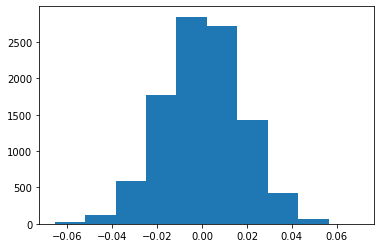

In [29]:
plt.hist(p_diffs)
plt.plot();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
sample_diff = treatment_prob - control_prob
(p_diffs > sample_diff).sum() / p_diffs.size

0.5471

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**ANS**: In words, the above computations showed that we have a 90.65% chance of observing the conversion probability difference between the old page and the new page (or greater) of our sample, given that H<sub>0</sub> is true. In scientific studies, this observation probability value is called the P-Value. This value can allow us to use our sample to estimate the difference in the conversion rate of our population especially when we compare it with our Type 1 error rate. Since our range for rejecting H<sub>0</sub> is 5% or lower, we can say comfortably that we fail to reject H<sub>0</sub> with the sample we have.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = control_df["converted"].sum()
convert_new = treatment_df["converted"].sum()
n_old = control_df.shape[0]
n_new = treatment_df.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], 0, 'larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**ANS:** Since the Z-Distribution is centered on 0, this means that little more than 50% of the difference in conversion proportion falls within the distribution of H<sub>0</sub>. This is confirmed by the p-value. The p-value seems significantly smaller here compared to the result found manually. However, the conclusions are the same, we fail to reject the H<sub>0</sub>.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**ANS:** Logistic Regression

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
dummy_df = pd.get_dummies(df2.group)
dummy_df.drop(columns="control", inplace=True)
dummy_df.rename(columns={"treatment":"ab_page"}, inplace=True)

In [35]:
df2["intercept"] = 1
df3 = df2.join(dummy_df)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
log_model = sm.Logit(df3["converted"], df3[["intercept", "ab_page"]])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-12-08 00:47 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**ANS:** The hypothesis in this situation is as follows:

H<sub>0</sub>: p<sub>ab_page(treatment)</sub> == p<sub>constant</sub>

H<sub>1</sub>: p<sub>ab_page(treatment)</sub> != p<sub>constant</sub>

This hypothesis looks for the change in conversion rate with the treatment page in any direction in comparision to the constant page. This is different from the hypothesis test we set up in part 2.

In other words the previous hypothesis test was a one-tailed test, while this one is a two-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**ANS:** The advantage of adding other variables could reduce the variability rate between the predicted explanatory variable and actual variability rate. However, this only happens if we assume that the additional variables are not co-linear with the current variable we are using. However, if there is a co-linearity, there is a disadvantage as it might not solve the variability issue and might even add more variabilty. Also, with more variables, the combination of variables to test goes up factorially, thus requiring some amount of field experience to feature engineer.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')

In [39]:
### Create the necessary dummy variables
country_dummies = pd.get_dummies(df_new.country)
country_dummies.drop(columns=["US"], inplace=True)
df_new = df_new.join(country_dummies)
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0


In [40]:
country_log_model = sm.Logit(df_new["converted"], df_new[["intercept", "CA", "UK"]])
results2 = country_log_model.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-12-08 00:47 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

Assuming the following hypothesis tests:

H<sub>0</sub>: *P*<sub>CA</sub> == *P*<sub>USA</sub>

H<sub>1</sub>: *P*<sub>CA</sub> != *P*<sub>USA</sub>

and 

H<sub>0</sub>: *P*<sub>UK</sub> == *P*<sub>USA</sub>

H<sub>1</sub>: *P*<sub>UK</sub> != *P*<sub>USA</sub>

where the *P* represents the probability of conversion. and a standard Type I error of 0.05, we can conclude with the p-values that there isn't substantial evidence to reject the null hypothesis and, thus, fail to do so.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
interactive_df = df_new[["intercept", "CA", "UK", "ab_page", "converted"]]
interactive_df["UK_ab_page"] = interactive_df["UK"] * interactive_df["ab_page"]
interactive_df["CA_ab_page"] = interactive_df["CA"] * interactive_df["ab_page"]

/Users/RohanKandi1/anaconda/envs/AB_Project_Env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/RohanKandi1/anaconda/envs/AB_Project_Env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
### Fit Your Linear Model And Obtain the Results
combined_log_model = sm.Logit(interactive_df["converted"], 
                              interactive_df[["intercept", "CA", "UK", "ab_page", "UK_ab_page", "CA_ab_page"]])
results3 = combined_log_model.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-12-08 00:47 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

**Conclusion**: The model fitted above adds new variables created by multiplying ab_page and the country dummy variables. Thus, *UK_ab_page* and *CA_ab_page* are the new variables on which we conduct similar double-tailed hypothesis tests as done with the other variables. Even with the interaction, the results obtained from the *Logit* method show no statistical significance with regards to the effect of the new variable holding the 0.05 $\alpha$ threshold. Thus, it seems that country variable, as a whole, does not seem to have much of an impact on the conversion rate and we fail to reject H<sub>0</sub>. However, it is important to note the important limitation of this conclusion that this sample of countries does not represent the entire world. The three countries here: Canada, USA and UK might be countries with significant overlap in preferences, thus making their statistical effect on conversion minimal. This might change when you bring in countries like China, Japan, India or EU.

Overall it seems that looking at the sample, the old website has a better conversion rate. This conclusion must be taken with a grain of salt as the reaction to the new webpage might be due to change aversion and the experiment needs to be run a few more weeks longer. However, with the overall change in conversion rate so small, it is practically negligible and there might be other more important factors that might warrant switching to a new website format.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.